# FINM 250 - TA Review 3 - CAPM
## Tobias Rodriguez del Pozo

## 1. What is the CAPM?

### 1.1 Overview

It states that **in the long run**, the expected return of a stock is equal to the risk-free rate plus a risk premium that is proportional to the stock's beta. That is, all returns are explained by the market:

$$
\mathbb{E}[r_i] = \beta_i \mathbb{E}[r_m]
$$
Where
$$
\beta_i = \frac{\text{Cov}(r_i, r_m)}{\text{Var}(r_m)}
$$

Typicall, we use the S&P 500 as a proxy for the market. The risk-free rate is normally the yield of the 3-month Treasury bill (or the repo rate). The broad class of "factor models" is a generalization of the CAPM. That is, the *core* idea of a factor model is that all returns are explained by a set of factors:

$$
\mathbb{E}[r_i] = \beta_{i,1} \mathbb{E}[r_{1}] + \beta_{i,2} \mathbb{E}[r_{2}] + \dots + \beta_{i,k} \mathbb{E}[r_{k}]
$$

For those who have seen factor models in statistics classes, they are the same thing. In typical factor model notation:

$$
\boldsymbol{X} = \boldsymbol{L} \boldsymbol{F} + \boldsymbol{\epsilon}
$$

Where $\boldsymbol{X}$ is a $p \times 1$ vector of features, $\boldsymbol{L}$ is a $p \times m$ *loadings* matrix, and $\boldsymbol{F}$ is a $m \times 1$ vector of uncorrelated, unobserved factors.

Most of the effort in constructing these kinds of models is in estimating the factors. Note how the response, $\boldsymbol{X}$, is *linear* in the loadings matrix. Thus, we can estimate the loadings matrix using linear regression. Importantly, being able to set up the factor model as a linear regression means that we can use all the very powerful tools that linear regression unlocks.

What statistical tool might we use to "go fishing" for factors? Hint: it involves the covariance matrix and uncorrelated vectors.

### 1.2 Implications

- $\alpha$, the intercept of the regression should be zero (or statistically indistinguishable from zero).
- The $R^2$ **does not matter** because the CAPM only care about the long run, not the deviations from the long run.
- Information ratio should be 0 (since $\alpha$ is 0).
- Treynor Ratio for *any* assets should be the same (since any differences in mean-returns can only be explained by differences in $\beta$).

### 1.3 Trading Strategies

How would you actually trade on the CAPM or a factor model? Well, consider that this is a pricing model. That is, it tells you what the *fair price* of an asset is (in terms of returns). So, if you have a lot of confidence in your factor model, you now have a theoretical price for every asset. 

If the market price is above your long-term theoretical price, you should short the asset. If the market price is below your long-term theoretical price, you should buy the asset.

Momentum was made popular by AQR ("Applied Quantitative Research"), a hedge fund. [A Half Century of Macro Momentum](https://www.aqr.com/Insights/Research/White-Papers/A-Half-Century-of-Macro-Momentum).

### 1.4 Misc. Regression Questions

These are all from interviews I've had or heard about. Again, these are not required for the class, but they are good to think about.

- Give the closed form solution for linear regression and the residuals.
- What happens to the betas, intercept, and R^2 if there is some measurement error in your X variables? What about Y?
- How do I determine if my betas are statistically significant?
- When would you want to use a weighted regression? What about a robust regression?
- What is the difference between a linear regression and a logistic regression? What is the canonical link function for a logistic regression?
- What is the closed form solution for a logistic regression? And Ridge regression?
- What is the difference between Ridge and Lasso regression?
- How would you determine if your regression is overfitting?

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# This is a new trick that we can use to import modules from other directories.
import sys

# We append it to "path" meaning that Python will look in this directory when we try to import modules.
# Note that ".." means go up one directory, and then we go into the "cmds" directory.
sys.path.append("../cmds")
from utils import calc_iterative_regression

# Auto reload modules.
%load_ext autoreload
%autoreload 2

# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.family"] = "serif"
plt.style.use("ggplot")

pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

ADJ = 12
factors = pd.read_excel(
    "../data/factor_pricing_data.xlsx",
    sheet_name="factors (excess)",
    index_col=0,
    parse_dates=[0],
)

spy = factors[["MKT"]]

assets = pd.read_excel(
    "../data/factor_pricing_data.xlsx",
    sheet_name="assets (excess)",
    index_col=0,
    parse_dates=[0],
)

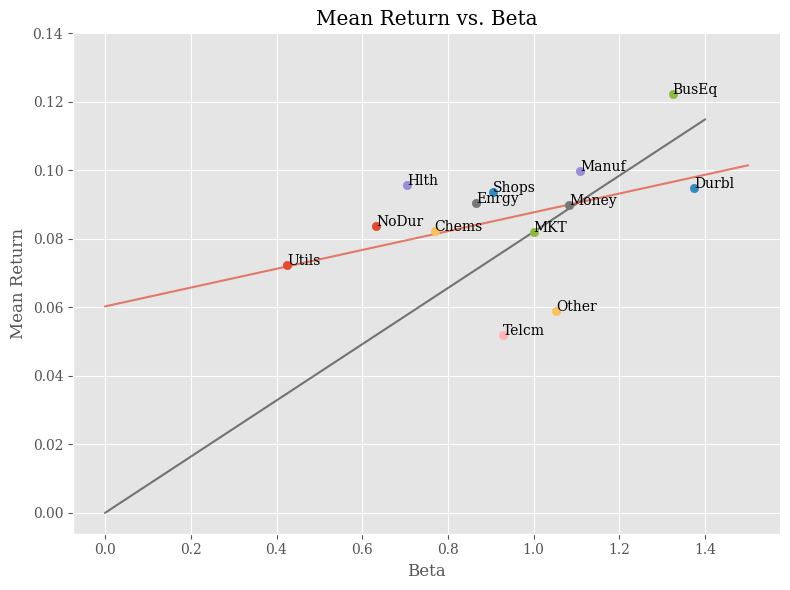

In [2]:
fig, ax = plt.subplots(figsize=(8, 6))

assets["MKT"] = spy

betas = []
means = []

spy_const = sm.add_constant(spy)
for asset in assets.columns:
    regr = sm.OLS(assets[asset], spy_const).fit()
    ax.scatter(regr.params[1], assets[asset].mean() * ADJ, label=asset, zorder=2)
    ax.annotate(asset, (regr.params[1], assets[asset].mean() * ADJ), zorder=3)
    betas.append(regr.params[1])
    means.append(assets[asset].mean() * ADJ)

ax.plot([0, 1.4], [0, spy.mean()[0] * ADJ * 1.4], c="black", zorder=1, alpha=0.5)
beta_mean_regr = sm.OLS(means, sm.add_constant(betas)).fit()

ax.plot(
    np.arange(0, 1.6, 0.1),
    beta_mean_regr.params[0] + beta_mean_regr.params[1] * np.arange(0, 1.6, 0.1),
    zorder=1,
    alpha=0.7,
)

ax.set_yticks(np.arange(0, 0.15, 0.02))
ax.set_xticks(np.arange(0, 1.6, 0.2))
ax.set_title("Mean Return vs. Beta")
ax.set_xlabel("Beta")
ax.set_ylabel("Mean Return")
fig.tight_layout()

## 2. Replication

(See TA solutions for the code).

## 3. Python

### Jupyter Notebook Tidbit #1: How to use the "magic" commands

Jupyter is actually a wrapper around the IPython kernel. IPython is a Python interpreter that has a bunch of extra features. One of these features is the "magic" commands. These are commands that start with a `%` or `%%` and are not part of the Python language. They are specific to IPython. 

So actually, code cells are just blocks of text that start with `%%python`, and a markdown cell is just a block of text that starts with `%%markdown`.

In [3]:
# Some examples. Let's look at the documentation for the `calc_iterative_regression` function.
# %pdoc calc_iterative_regression

# Or time some code.
# %timeit calc_iterative_regression(assets, spy, one_to_many=True)

# Or list all variables of type `DataFrame` in the current namespace.
# %whos DataFrame

# Or run a specific file
# %run ../cmds/utils.py

# Or load it!
#  %load ../cmds/utils.py

### Python Tidbit #1 (from last week)

In [4]:
rets = pd.read_excel(
    "../data/multi_asset_etf_data.xlsx",
    sheet_name="excess returns",
    index_col=0,
    parse_dates=[0],
)

# Here is another example of dictionary unpacking and where it can be useful.
# Recall from the calc_iter_regr(y, X, intercept=True, one_to_many=False, adj=12) function,
# that we have 3 different parameters that we can set. Suppose that for *this* notebook in
# particular, we want to change all of them. However, we don't want to have to repeatedly call
# the function with different parameters, eg:

calc_iterative_regression(
    rets[["IEF", "HYG", "PSP"]],
    rets[["SPY"]],
    intercept=False,
    one_to_many=True,
    adj=52,
)

# We can simply make a dictionary of the parameters we want to change, and then unpack it into
# the function.

PARAMS = {"intercept": False, "one_to_many": True, "adj": 52}

calc_iterative_regression(rets[["IEF", "HYG", "PSP"]], rets[["SPY"]], **PARAMS)

# We can also use something like functools.partial to *partially* apply the function with the
# parameters we want to change. This is useful if we want to change multiple parameters, perhaps
# in a more complex way, or by personal preference. This pre-applies the parameters we want to change,
# and returns a new function that we can call with the remaining parameters.

from functools import partial

calc_iter_regr_partial = partial(
    calc_iterative_regression, intercept=False, one_to_many=True, adj=12
)

calc_iter_regr_partial(rets[["IEF", "HYG", "PSP"]], rets[["SPY"]])

# Finally, note how we're constantly repeating rets[["IEF", "HYG", "PSP"]] and rets["SPY"] in the
# function calls! We could fix this with another partial function, but we can also use list unpacking.
VAR_LIST = [rets[["IEF", "HYG", "PSP"]], rets[["SPY"]]]

# This is what Python means when you see a function that looks like: func(*args, **kwargs)
# Note how we can end the line with a ';' to suppress the output of the function call.
calc_iterative_regression(*VAR_LIST, **PARAMS);

### Python Tidbit #2: What governs being able to do operations on two different datetypes?

This is based on a question I got last week, which I thought warranted a more in-depth discussion.

In [5]:
# Why can we do this?
as_np = np.arange(10)
as_pd = pd.Series(as_np)
# display(as_np + 10)
# display(as_pd + 10)
# display(as_np + as_pd)

# But not this?
my_list = list(range(10))
# my_list + 10

# And not this?
as_pd_reindex = as_pd.reindex(range(10, 20))
# as_pd + as_pd_reindex

# Or this?
as_np_short = np.arange(5)
# as_np + as_np_short

# Or this?
# as_pd + "A"

# It's weird, right? Why can we sometimes add a scaler to a series, an array, but not
# to a list?

# A surface level explanation is that the "+" operator is defined for list concatenation,
# but not for addition. But why?

In [6]:
# We introduce another special method, __add__(), which is called when we use the "+" operator.
# It allows us to *define* what happens when we use the "+" operator on our own classes, and what
# it means to add two instances of our class together - or to add our class to another class.

# Suppose I am fed up of not being able to add a scaler to a list, and I want to define my own
# class that allows me to do this. I can do this by defining my own class, and defining the __add__()
# method to work for my class.

# Why might this be a bad idea? Hint: Line 513 of this file: https://github.com/python/cpython/blob/main/Objects/listobject.c
# What language is this file in? What does this mean for performance of TobiasList?


class TobiasList(list):
    # Iterator and dictionary unpacking!
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __add__(self, other):
        # Check if this is a scaler.
        if isinstance(other, int) or isinstance(other, float):
            return [i + other for i in self]
        else:
            # Otherwise, just use the default list addition.
            return super().__add__(other)

    def __mul__(self, other) -> list:
        # Check if this is a scaler.
        if isinstance(other, int) or isinstance(other, float):
            return [i * other for i in self]
        else:
            # Otherwise, just use the default list addition.
            return super().__mul__(other)

    def __pow__(self, other) -> list:
        if isinstance(other, int) or isinstance(other, float):
            return [i**other for i in self]
        else:
            return super().__pow__(other)


# TobiasList(range(10)) + 10
# TobiasList(range(10)) * 10
# TobiasList(range(10)) ** 2

### Pandas Tidbit: Everything in Pandas is an Index Operation

*All* Pandas operations are index operations. That is, they are operations on the index of the DataFrame. This is why Pandas is so fast. It is also why Pandas is so confusing and hard to debug. If you understand indexing, you understand Pandas.

From TA Review 1: https://www.youtube.com/watch?v=pjq3QOxl9Ok


In [7]:
df_1 = pd.DataFrame(np.random.randn(10, 10))
df_2 = pd.DataFrame(np.random.randn(10, 10))

# This works!
# display(df_1 + df_2)

# This also works!
df_1[10] = df_2[0]
# display(df_1)

# Why? Because the indices of df_1 and df_2 are the same, so pandas knows how to add them together,
# set one to the other, etc. Now let's change the indices and see what happens.
df_2.index = range(2, 12)

# We can only add where the indices match,
# otherwise we get NaNs.
# display(df_1 + df_2)

# The same thing goes for setting
df_1[10] = df_2[0]
# display(df_1)

# So how do we actually fix this problem? There are a few ways.
df_1 = pd.DataFrame(np.random.randn(10, 10))
df_2 = pd.DataFrame(np.random.randn(10, 10))
df_2.index = range(2, 12)

# First, we reindex df_2 to match df_1.
df_2.index = df_1.index
# display(df_1 + df_2)

# Second, we can use the .add() method, which allows us to specify how we want to handle
# missing values. This will fill in missing values with 0.
# display(df_1.add(df_2, fill_value=0))

# Third, we can reset the index of both dataframes, such that their indices are the same (0,...,9).
df_2 = df_2.reset_index(drop=True)
df_1 = df_1.reset_index(drop=True)
# display(df_1 + df_2)

# Finally, we can use the .align() method, which will align the indices of both dataframes,
# and fill in missing values with NaNs.
df_1, df_2 = df_1.align(df_2, axis=0)
# display(df_1 + df_2)

In [30]:
# Index alignment also helps us answer questions, such as why these two cells run at different speeds.

# For-loop creation of dataframes with string indices.
my_dfs_idx = []
my_dfs = []

letters = "abcdefghijlmnopqrstuvwxyz"

for i in range(10000):
    my_dfs_idx.append(
        pd.DataFrame(
            np.random.randn(25, 10), index=[letters[j] + str(i) for j in range(25)]
        )
    )
    my_dfs.append(pd.DataFrame(np.random.randn(25, 10)))

In [31]:
# Concat with no index dropping.
%timeit res = pd.concat(my_dfs, axis=0)

573 ms ± 63.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
# Concat with index dropping.
%timeit res = pd.concat(my_dfs, axis=0, ignore_index=True)

520 ms ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
